In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [62]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=50

In [5]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [35]:
### Preproccessing Data ###

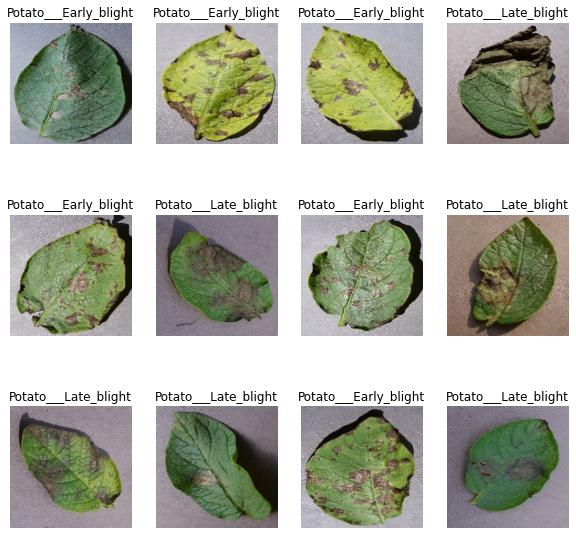

In [13]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    #Print All image
#     print(image_batch.shape)
#     print(label_batch.numpy())
      #32 numberofimages, each image size is 256X256, 3 channels (RGB)
    #Print single image
#     plt.imshow(image_batch[0].numpy().astype("uint8"))
#     plt.title(class_names[label_batch[0]])
#     plt.axis("off")
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [14]:
# 80% (0.8)==> for training
# 20% (0.2)==> 10% for validation, 10% for test the accuracy of model

In [15]:
len(dataset)

68

In [16]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [22]:
def get_dataset_pertitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = get_dataset_pertitions_tf(dataset)

In [24]:
len(train_ds)

54

In [25]:
len(val_ds)

6

In [26]:
len(test_ds)

8

In [ ]:
# optimizing Tensorflow pipeline Performance : prefetch & cache
# https://www.youtube.com/watch?v=MLEKEplgCas

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [28]:
# During the prediction when we are supplying any image which is not to 256X256 image (different dimention) this function takecare of resizing the image
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [31]:
# Data Augmantation
# """Data augmentation is a way of creating new 'data' with different orientations. 
# The benefits of this are two-fold, the first being the ability to generate 'more data' from limited data and secondly, 
# it prevents overfitting.""".

In [34]:
data_augmantation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [37]:
### Model Building ###
# Using CNN for build the model
# CNN using for image classification Problem
# Conv2D = https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

In [43]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmantation,
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
#Compiling the Model
#We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [45]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [46]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 206s 3s/step - loss: 0.9128 - accuracy: 0.4797 - val_loss: 0.7902 - val_accuracy: 0.5052
Epoch 2/50
54/54 [==============================] - 101s 2s/step - loss: 0.7293 - accuracy: 0.6366 - val_loss: 0.5059 - val_accuracy: 0.7448
Epoch 3/50
54/54 [==============================] - 94s 2s/step - loss: 0.5318 - accuracy: 0.7523 - val_loss: 0.4445 - val_accuracy: 0.7865
Epoch 4/50
54/54 [==============================] - 93s 2s/step - loss: 0.3269 - accuracy: 0.8623 - val_loss: 0.2692 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 93s 2s/step - loss: 0.2607 - accuracy: 0.8918 - val_loss: 0.1751 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 92s 2s/step - loss: 0.1982 - accuracy: 0.9207 - val_loss: 0.1474 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 95s 2s/step - loss: 0.2151 - accuracy: 0.9132 - val_loss: 0.1648 - val_accuracy: 0.9323
Epoch 8/50
54/54 [

In [ ]:
### Saving the Model
# We append the model to the list of models as a new version

In [73]:
# import os
# model_version=max([int(i) for i in os.listdir("../ModelsVersion") + [0]])+1
# model.save(f"../ModelsVersion/{model_version}")

INFO:tensorflow:Assets written to: ../ModelsVersion/1\assets


INFO:tensorflow:Assets written to: ../ModelsVersion/1\assets


In [47]:
model.save("../Models/potatoDiseaseCNN.h5")

C:\Users\mmjes\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
#You can see above that we get 100.00% accuracy for our test dataset. 
#This is considered to be a pretty good accuracy

In [48]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 10s 503ms/step - loss: 0.0394 - accuracy: 0.9844


In [50]:
#Scores is just a list containing loss and accuracy value

In [51]:
scores

[0.03938679397106171, 0.984375]

In [52]:
#Plotting the Accuracy and Loss Curves

In [58]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [54]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [55]:
#loss, accuracy, val loss etc are a python list containing values of loss,
#accuracy etc at the end of each epoch

In [56]:
type(history.history['loss'])

list

In [57]:
len(history.history['loss'])

50

In [59]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9128232598304749,
 0.7292512059211731,
 0.5318076610565186,
 0.3269308805465698,
 0.26070454716682434]

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

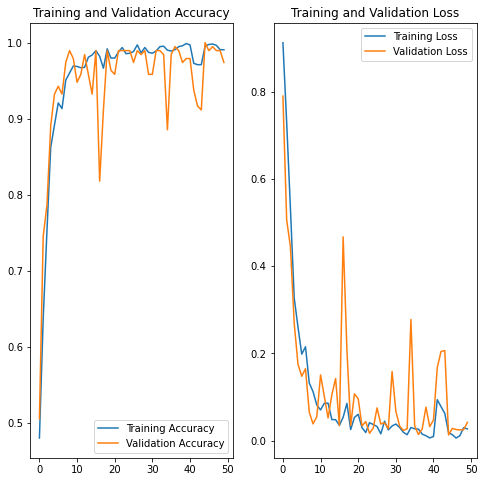

In [63]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [64]:
### Run prediction on a sample image ###

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 550ms/step
predicted label: Potato___Early_blight


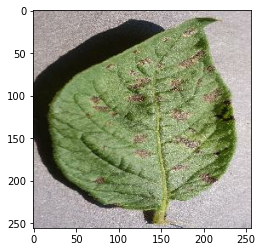

In [67]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [68]:
### Write a function for inference

In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [70]:
### Now run inference on few sample images

1/1 [==============================] - 0s 46ms/step


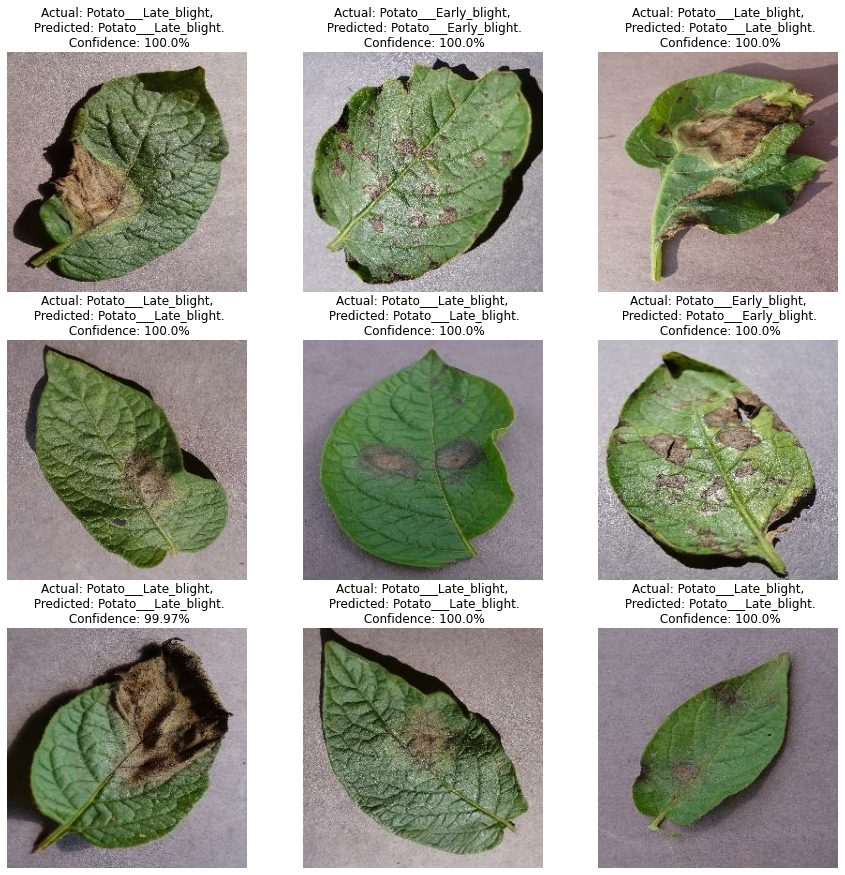

In [71]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")